As a stretch activity, we will be adapting another person's work on crime cluster analysis for spatiotemporal clustering and applying it to our own data to see if we can find any trends with Boroughs and Precincts

In [1]:
# Implort libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

from scipy import stats

import seaborn as sns
import matplotlib as mpl

import geopandas
import geoplot
import geoplot.crs as gcrs
from shapely.geometry import Polygon, Point

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import random
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import sys


In [2]:
#Base matplot parameters
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"   
mpl.rcParams['font.size'] = 13
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5   

#Set colours for clusters
cluster_colors = ["#e74c3c", "#34495e", "#2ecc71", "#3498db"]

# Preprocessing Maps

In [3]:
#Connect to google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Precinct Map

In [4]:
#load dataframe
path = "/content/drive/MyDrive/mini/Precincts_geo/nypp.shp"

# open shapefile
pcints = geopandas.read_file(path).to_crs(epsg=4326)

# clean a variable dtypes
pcints['pct'] = pcints['Precinct'].astype('int32')

# create a new, clean GeoDataFrame
clean_map = geopandas.GeoDataFrame()
clean_map['Precinct'] = pcints['pct'].unique()
clean_map['geometry'] = [Polygon(max(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union, key=lambda a: a.area).exterior) if pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.geom_type == 'MultiPolygon' else Polygon(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.exterior) for pct in clean_map.Precinct]

In [5]:
#view map
clean_map

,Precinct,geometry
0,1,"POLYGON ((-73.99761 40.72580, -73.99677 40.725..."
1,5,"POLYGON ((-73.98864 40.72293, -73.98869 40.722..."
2,6,"POLYGON ((-73.99968 40.73855, -73.99684 40.737..."
3,7,"POLYGON ((-73.97345 40.71896, -73.97351 40.718..."
4,9,"POLYGON ((-73.97161 40.72672, -73.97163 40.726..."
...,...,...
72,115,"POLYGON ((-73.85908 40.76252, -73.85943 40.762..."
73,120,"POLYGON ((-74.05357 40.60370, -74.05407 40.603..."
74,121,"POLYGON ((-74.17988 40.64511, -74.17984 40.645..."
75,122,"POLYGON ((-74.10723 40.61025, -74.10668 40.610..."


## Borough Map

In [6]:
#load dataframe
path = "/content/drive/MyDrive/mini/Boroughs_geo/nybbwi.shp"

# open shapefile
boroughs = geopandas.read_file(path).to_crs(epsg=4326)

# clean a variable dtypes
boroughs['Code'] = boroughs['BoroCode'].astype('int32')

# create a new, clean GeoDataFrame
boro_map = geopandas.GeoDataFrame()
boro_map['BoroCode'] = boroughs['Code']
boro_map['BoroName'] = boroughs['BoroName']
boro_map['geometry'] = [Polygon(max(boroughs.loc[boroughs['Code'] == code,
                        'geometry'].unary_union, key=lambda a: a.area).exterior) if boroughs.loc[boroughs['Code'] == code, 
                                  'geometry'].unary_union.geom_type == 'MultiPolygon' else Polygon(boroughs.loc[boroughs['Code'] == code, 'geometry'].unary_union.exterior) for code in boro_map.BoroCode]

In [7]:
#view map
boro_map

,BoroCode,BoroName,geometry
0,1,Manhattan,"POLYGON ((-73.92478 40.87890, -73.92472 40.878..."
1,2,Bronx,"POLYGON ((-73.86477 40.90201, -73.86305 40.901..."
2,3,Brooklyn,"POLYGON ((-73.92722 40.72533, -73.92654 40.724..."
3,5,Staten Island,"POLYGON ((-74.05581 40.64971, -74.05619 40.639..."
4,4,Queens,"POLYGON ((-73.77896 40.81171, -73.76371 40.793..."


# Data Processing

## Pre-Covid Data

In [8]:
#load data
path = "/content/drive/MyDrive/mini/pre_c_crime_2.csv"
pre_covid = pd.read_csv(path)

# transform to datetime
pre_covid['ARREST_DATE'] = pd.to_datetime(pre_covid['ARREST_DATE'])
pre_covid.rename(columns={"ARREST_PRECINCT":"Precinct", 'ARREST_BORO':'BoroName'}, inplace = True)

#replace ordinal values to name of boro
pre_covid.loc[pre_covid["BoroName"] == 0, "BoroName"] = "Bronx"
pre_covid.loc[pre_covid["BoroName"] == 1, "BoroName"] = "Brooklyn"
pre_covid.loc[pre_covid["BoroName"] == 2, "BoroName"] = "Manhattan"
pre_covid.loc[pre_covid["BoroName"] == 3, "BoroName"] = "Queens"
pre_covid.loc[pre_covid["BoroName"] == 4, "BoroName"] = "Staten Island"

#Add day column
pre_covid['Day'] = pre_covid.ARREST_DATE.dt.day

#View
pre_covid.head()

,ARREST_DATE,WeekDay,Month,Crime Severity,BoroName,Precinct,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,New Georeferenced Column,Day
0,2019-03-01,4,3,1,Manhattan,14,1,1,2,40.757578,-73.989545,POINT (-73.98954452399994 40.75757811200003),1
1,2019-03-01,4,3,0,Queens,109,0,1,4,40.781417,-73.778168,POINT (-73.77816787699999 40.78141724100004),1
2,2019-03-01,4,3,0,Brooklyn,60,0,1,2,40.575574,-73.981204,POINT (-73.98120362499998 40.575573630000065),1
3,2019-03-01,4,3,1,Brooklyn,79,0,1,2,40.688378,-73.944912,POINT (-73.94491165999996 40.68837827800007),1
4,2019-03-01,4,3,0,Bronx,41,2,1,5,40.814684,-73.891918,POINT (-73.89191764199995 40.81468425600008),1


## Covid Data

In [9]:
#Load Data
path = "/content/drive/MyDrive/mini/c_crime_2.csv"
covid = pd.read_csv(path)

# transform to datetime
covid['ARREST_DATE'] = pd.to_datetime(covid['ARREST_DATE'])
covid.rename(columns={"ARREST_PRECINCT":"Precinct", 'ARREST_BORO':'BoroName'}, inplace = True)

#replace ordinal values to name of boro
covid.loc[covid["BoroName"] == 0, "BoroName"] = "Bronx"
covid.loc[covid["BoroName"] == 1, "BoroName"] = "Brooklyn"
covid.loc[covid["BoroName"] == 2, "BoroName"] = "Manhattan"
covid.loc[covid["BoroName"] == 3, "BoroName"] = "Queens"
covid.loc[covid["BoroName"] == 4, "BoroName"] = "Staten Island"

#Add day column
covid['Day'] = covid.ARREST_DATE.dt.day

#View
covid.head()

,ARREST_DATE,WeekDay,Month,Crime Severity,BoroName,Precinct,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,New Georeferenced Column,Day
0,2020-03-01,6,3,2,Brooklyn,70,0,1,2,40.647951,-73.960606,POINT (-73.96060645599994 40.64795139700004),1
1,2020-03-01,6,3,0,Staten Island,120,2,1,5,40.645023,-74.077217,POINT (-74.077216847 40.645022746000045),1
2,2020-03-01,6,3,2,Bronx,42,1,1,2,40.829510,-73.888056,POINT (-73.88805604799995 40.829510293000055),1
3,2020-03-01,6,3,2,Brooklyn,73,2,0,2,40.672574,-73.910176,POINT (-73.91017639799998 40.67257395100007),1
4,2020-03-01,6,3,0,Queens,113,1,1,2,40.677514,-73.789838,POINT (-73.78983757299993 40.67751412800004),1


# Precinct

In [10]:
#defined function to create number of clusters
def make_clusters(data, n):
    """
    This function creates the number of clusters based on your data.

    The dataframe you input, will Pull the Latitude, Longitude and Day columns.
    Then it will apply a standard scaller and Kmeans clustering based on the 
    number of clusters you want "n".

    After the model, it extracts the kmeans labels and value counts to print the
    sizes of each cluster as well.

    The function also calculates the silhouette score.
    """
    data = data[['Latitude', 'Longitude', 'Day']]
    data['Day'] = data['Day']
    
    # scale features
    stdscaler = StandardScaler()
    features = stdscaler.fit_transform(data)
    cluster = KMeans(n_clusters = n)
    model = cluster.fit(features)
    
    # re-label so that cluster 0 is always the largest and so on.
    data['labels'] = model.labels_
    re_labeling = data.labels.value_counts().reset_index()['index']
    data['new_labels'] = data['labels'].replace(list(re_labeling.values), list(re_labeling.index))
    
    print('Cluster sizes:')
    print(data.new_labels.value_counts())
    
    preds = cluster.fit_predict(features)
    score = silhouette_score(features, preds, metric='euclidean')
    print('Silhouette Score:', score)
    
    return data.new_labels.values

#create map of a selected precinct
def precinct_selected(precinct, basemap, save=False):  
    """
    This function creates a map showing the selected precinct inputed.

    First creating a column of 0's and 1's, 1 representing the row of the precinct
    of your choosing.

    Then it takes the precinct base map and plots the selected precinct
    """
    #create column on datframe and select for precinct inputed
    basemap['selected'] = np.where(basemap.Precinct == precinct, 1, 0)   
    
    #make plot
    fig, ax = plt.subplots(figsize = (8,8))

    # create map from basemap
    base = basemap.plot(ax=ax, color='white', edgecolor='black')
    basemap.plot(column = 'selected', ax =base, cmap = 'Greys')
  
    plt.show()

#defined function that plots clusters on the precinct map
def view_clusters(basemap, labeled_data, save=False):
    """
    This takes the number of clusters you have selected for your selected precinct
    and maps it on the precinct's map.

    basemap - the precinct basemap
    labeled_data - clustered data you want to map

    First it prints the raw training data

    Second it prints the clustered data
    """
    # view raw training data
    ax = geoplot.polyplot(basemap[basemap.Precinct == labeled_data.Precinct.values[0]], figsize=(8, 8), 
                          lw= 2, facecolor= 'None', edgecolor='k', alpha=1)  
    
    for i in range(len(labeled_data.labels.unique())):
        ax.scatter(labeled_data[labeled_data.labels == i]['Longitude'], 
                   labeled_data[labeled_data.labels == i]['Latitude'], color='k', alpha=.75, s=100)
    
    if save:
        plt.savefig('Figures/precinct_zoom_black.png', dpi=300)        
    
    # view clustered data
    ax = geoplot.polyplot(basemap[basemap.Precinct == labeled_data.Precinct.values[0]], 
                          figsize=(8, 8), lw= 2, facecolor= 'None', edgecolor='k', alpha=1)  
    
    for i in range(len(labeled_data.labels.unique())):
        ax.scatter(labeled_data[labeled_data.labels == i]['Longitude'], 
                   labeled_data[labeled_data.labels == i]['Latitude'], 
                   color=cluster_colors[i], alpha=.75, s=100)

    if save:
        plt.savefig('Figures/precinct_zoom_clustered.png', dpi=300)

## Select Precinct and Map

I will be running this code during 2 time frames for both covid and pre-covid to extract their cluster and contour plots.

First timeframe represents wave 1 of covid: March 15/2020 - May 15 2020

First timeframe represents a non-wave of covid: July 15/2020 - September 15 2020

These will cover 2 months of data in our dataframes and give us a snap shot of what is happening with our data based on longitude, latitude and day of the month.

In [11]:
# select the parameters of the algorithm
precinct = 75
n_clusters = 2
n_levels = 2

#pre covid_training
pre_period = ['2019-07-15', '2019-09-15']

#covid training
period_cov = ['2020-07-15', '2020-09-15']


# here we separate training and testing data for pre- covid 
training_pre = pre_covid[(pre_covid.ARREST_DATE > pre_period[0]) & (
    pre_covid.ARREST_DATE < pre_period[1]) & (pre_covid.Precinct == precinct)]

# here we separate training and testing data for covid
training_cov = covid[(covid.ARREST_DATE > period_cov[0]) & (
    covid.ARREST_DATE < period_cov[1]) & (covid.Precinct == precinct)]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


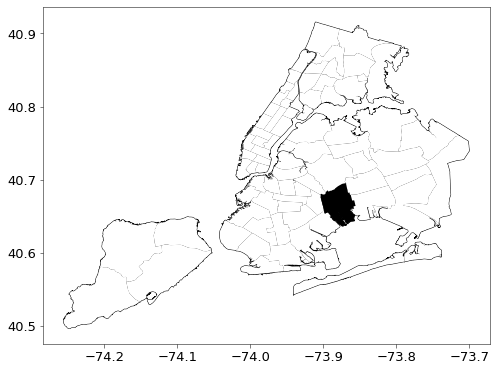

In [12]:
# showing selected precinct
precinct_selected(precinct, clean_map, save=False)


## Clustering Results

In [13]:
#run kmeans training clustering on dataset
training_pre['labels'] = make_clusters(training_pre, 3)

Cluster sizes:
2    433
0    383
1    193
Name: new_labels, dtype: int64
Silhouette Score: 0.28413719350596894


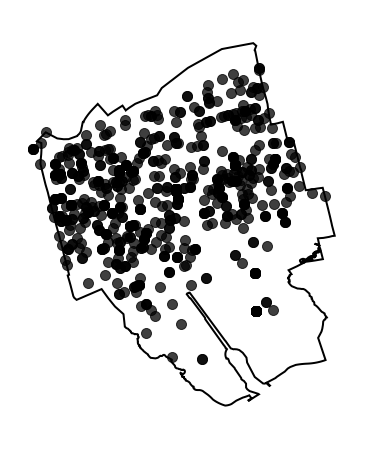

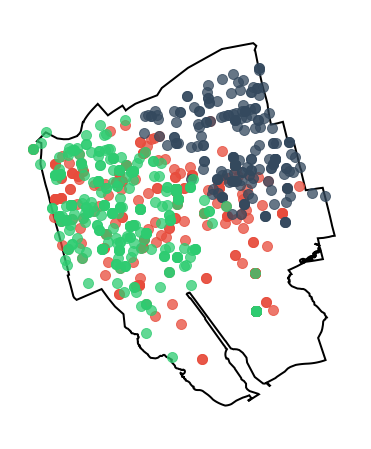

In [14]:
#View precovid cluster for precinct 75
view_clusters(clean_map, training_pre, save = False)

In [15]:
#run kmeans training clustering on dataset
training_cov['labels'] = make_clusters(training_cov, 3)

Cluster sizes:
0    216
1    156
2    114
Name: new_labels, dtype: int64
Silhouette Score: 0.31965889528919045


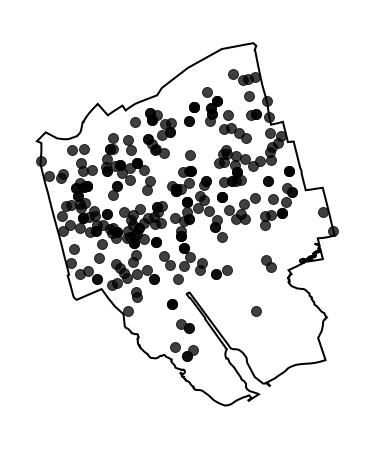

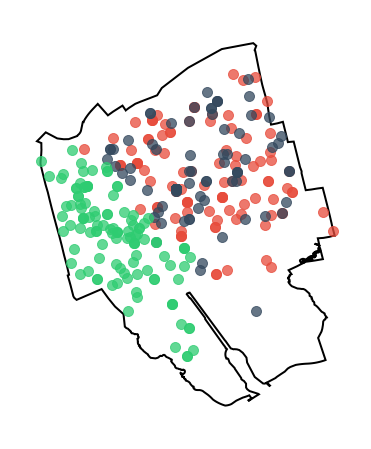

In [16]:
#view covid precinct 75
view_clusters(clean_map, training_cov, save = False)

## Fitting a gaussian KDE

In [17]:
# defined function to make contours with Gaussian KDE.
def make_contour(Longitude, Latitude, basemap_polygon, colors, levels):
    """
    This function makes gaussian KDE contours with defined Longitude and Latitude
    limits for the specified precinct/borough.

    Return the XY coordinates for the points in the KDE
    """

    #Name variables
    x = Longitude
    y = Latitude
    
    # check bounds
    xmin = basemap_polygon.bounds['minx'].values - 0.0025
    xmax = basemap_polygon.bounds['maxx'].values + 0.0025
    ymin = basemap_polygon.bounds['miny'].values - 0.0025
    ymax = basemap_polygon.bounds['maxy'].values + 0.0025
    
    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    #Locations of KDE on plot
    cset = plt.contour(xx, yy, f, colors=colors, levels=levels, linewidths=1.5)
    
    #return XY coordinates for the points in KDE
    return cset

# defined function takes coordinates of make_contours  and selects the level n
def get_level(contour, n):
    """
    The contours that are created in make_contours are inputted into this function.
    and select the number of levels we are interested in.

    Backwards, outermost level is 0

    Returns a list of levels for the contours
    """
    x = []
    y = []
    for j in range(len(contour.allsegs)):
        for ii, seg in enumerate(contour.allsegs[j]):
            x += [seg[:,0]]
            y += [seg[:,1]]
    
    return list(zip(x[n], y[n])) 

#defined function grabs the contours for each cluster, selects the level we want and plots the results
def get_view_contours(basemap, labeled_data, precinct, levels, plot=False, save=False):
    """
    This function takes your based map and selected clustered data to plot on
    the selected precincts clusters based on guassian KDE contours
    """
    fig, ax = plt.subplots()
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    
    # make contours for each cluster
    contours = []
    for i in range(len(labeled_data.labels.unique())):
        ctr = make_contour(labeled_data[labeled_data.labels == i]['Longitude'], #used make_contours function
                           labeled_data[labeled_data.labels == i]['Latitude'], 
                           basemap[basemap.Precinct == labeled_data.Precinct.values[0]]['geometry'], 
                           colors=cluster_colors[i], levels=levels)
        contours += [ctr]

    levels = [get_level(x, 0) for x in contours] #use get_level function

    #plot contours
    if plot:
        ax = geoplot.polyplot(basemap[basemap.Precinct == labeled_data.Precinct.values[0]], 
                              figsize=(8, 8), lw= 2, facecolor= 'None', edgecolor='k', alpha=1)
        for i in range(len(labeled_data.labels.unique())):
            # plot contour edges
            ax.plot([x[0] for x in levels[i]], [x[1] for x in levels[i]], color=cluster_colors[i], lw=5)
            # fill the area
            ax.fill_between([x[0] for x in levels[i]], [x[1] for x in levels[i]], 
                            facecolor=cluster_colors[i], alpha=.3)
    #if saving
        if save:
            plt.savefig('Figures/precinct_zoom_clustered_kde_no_scatter.png', dpi=300)
    return levels




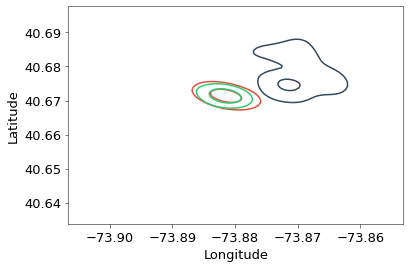

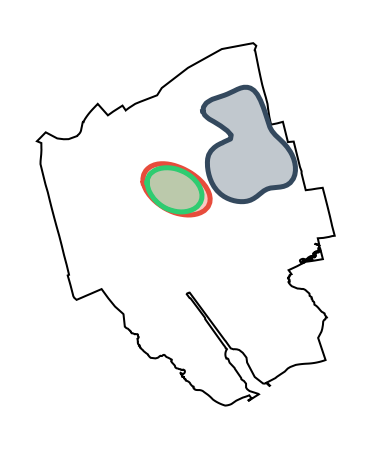

In [18]:
#View contours pre covid for precinct 75
contours = get_view_contours(clean_map, training_pre, precinct, n_levels, plot=True, save=False)

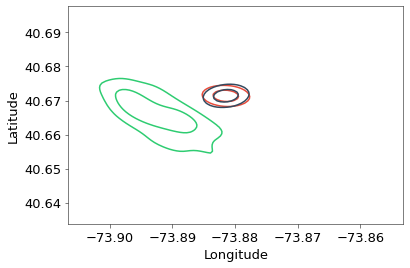

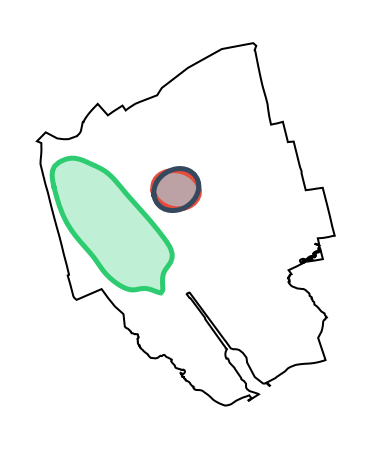

In [19]:
#View contours during covid for precinct 75
contours = get_view_contours(clean_map, training_cov, 75, n_levels, plot=True, save=False)

# Borough

In [20]:
# Defined function to plot Boro clusters on map
def view_boro_clusters(basemap, labeled_data, save=False):
    """
    This function creates the number of clusters based on your data.

    The dataframe you input, will Pull the Latitude, Longitude and Day columns.
    Then it will apply a standard scaller and Kmeans clustering based on the 
    number of clusters you want "n".

    After the model, it extracts the kmeans labels and value counts to print the
    sizes of each cluster as well.

    The function also calculates the silhouette score.
    """
    
    # view raw training data
    ax = geoplot.polyplot(basemap[basemap.BoroName == labeled_data.BoroName.values[0]], figsize=(8, 8), 
                          lw= 2, facecolor= 'None', edgecolor='k', alpha=1)  
    
    #run through Longitude and Latitude
    for i in range(len(labeled_data.labels.unique())):
        ax.scatter(labeled_data[labeled_data.labels == i]['Longitude'], 
                   labeled_data[labeled_data.labels == i]['Latitude'], color='k', alpha=.75, s=100)
    
    if save:
        plt.savefig('boro_zoom_black.png', dpi=300)        
    
    # plot clustered data
    ax = geoplot.polyplot(basemap[basemap.BoroName == labeled_data.BoroName.values[0]], 
                          figsize=(8, 8), lw= 2, facecolor= 'None', edgecolor='k', alpha=1)  
    
    for i in range(len(labeled_data.labels.unique())):
        ax.scatter(labeled_data[labeled_data.labels == i]['Longitude'], 
                   labeled_data[labeled_data.labels == i]['Latitude'], 
                   color=cluster_colors[i], alpha=.75, s=100)

    if save:
        plt.savefig('boro_zoom_clustered.png', dpi=300)

#Defined function to view selected borough
def boro_selected(boro, basemap, save=False):  
    """
    This function creates a map showing the selected precinct inputed.

    First creating a column of 0's and 1's, 1 representing the row of the precinct
    of your choosing.

    Then it takes the precinct base map and plots the selected precinct
    """
    #create column to identify row of boro you want
    basemap['selected'] = np.where(basemap.BoroName == boro, 1, 0)   
    
    #Set up map
    fig, ax = plt.subplots(figsize = (8,8))

    # create map from basemap
    base = basemap.plot(ax=ax, color='white', edgecolor='black')
    basemap.plot(column = 'selected', ax =base, cmap = 'Greys')
  
    plt.show()


## Select Boro, parameters and Map

I will be running this code during 2 time frames for both covid and pre-covid to extract their cluster and contour plots.

First timeframe represents wave 1 of covid: March 15/2020 - May 15 2020

First timeframe represents a non-wave of covid: July 15/2020 - September 15 2020

These will cover 2 months of data in our dataframes and give us a snap shot of what is happening with our data based on longitude, latitude and day of the month.

In [21]:
# select the parameters of the algorithm 
boro = 'Brooklyn'
n_clusters = 2
n_levels = 2

#Pre-covid
boro_period = ['2019-07-15', '2019-09-15']

#Covid
boro_period_cov = ['2020-07-15', '2020-09-15']


# here we separate training and testing data for pre- covid 
boro_pre = pre_covid[(pre_covid.ARREST_DATE > boro_period[0]) & (
    pre_covid.ARREST_DATE < boro_period[1]) & (pre_covid.BoroName == boro)]

# here we separate training and testing data for covid
boro_cov = covid[(covid.ARREST_DATE > boro_period_cov[0]) & (
    covid.ARREST_DATE < boro_period_cov[1]) & (covid.BoroName == boro)]

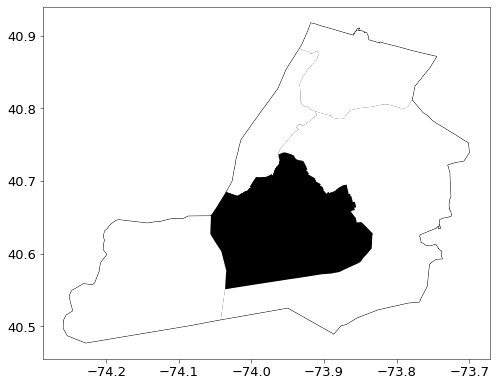

In [22]:
# showing selected precinct
boro_selected(boro, boro_map, save=False)


## Clustering Results

In [23]:
#run kmeans training pre-covid clustering on dataset
boro_pre['labels'] = make_clusters(boro_pre, 2)

Cluster sizes:
1    6062
0    2921
Name: new_labels, dtype: int64
Silhouette Score: 0.3097209622267327


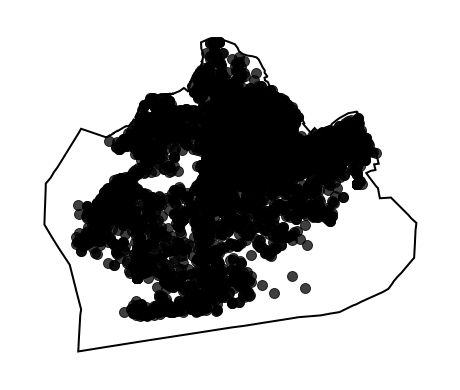

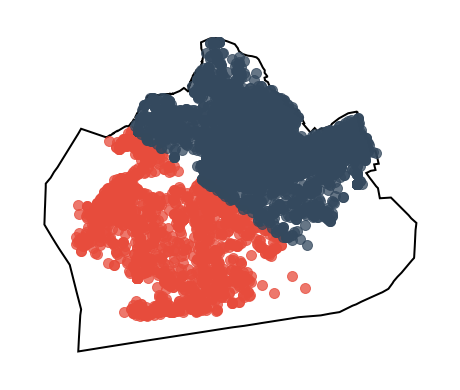

In [24]:
#View brooklyn pre covid clusters for Brooklyn
view_boro_clusters(boro_map, boro_pre, save = False)

In [25]:
#run kmeans training covid clustering on dataset for brooklyn
boro_cov['labels'] = make_clusters(boro_cov, 2)

Cluster sizes:
0    3260
1    1770
Name: new_labels, dtype: int64
Silhouette Score: 0.3191794651633595


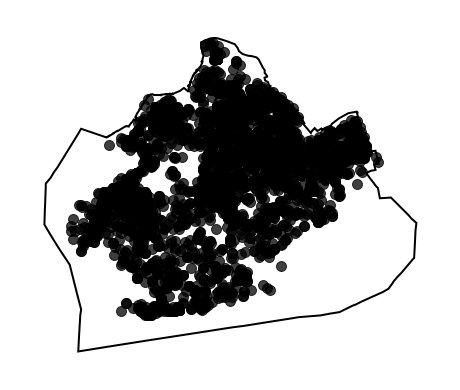

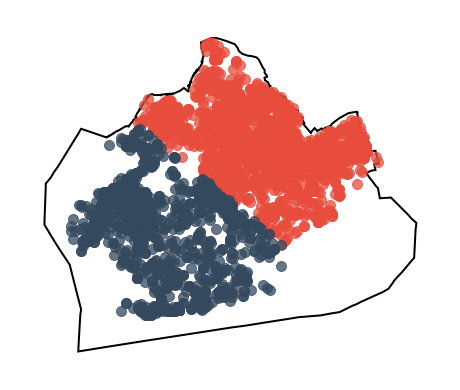

In [26]:
#View brooklyn pre covid clusters for Brooklyn
view_boro_clusters(boro_map, boro_cov, save = False)

## Fitting a Gaussian KDE

In [29]:
# grabs the contours for each cluster, selects the level we want and plots the results
def get_view_contours_boro(basemap, labeled_data, boro, levels, plot=False, save=False):
    """
    This function takes your based map and selected clustered data to plot on
    the selected borough clusters based on guassian KDE contours
    """
    #Set up plot
    fig, ax = plt.subplots()
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    
    # make contours for each cluster and plot on normal plot
    contours = []
    for i in range(len(labeled_data.labels.unique())):
        ctr = make_contour(labeled_data[labeled_data.labels == i]['Longitude'], #use make_contours function
                           labeled_data[labeled_data.labels == i]['Latitude'], 
                           basemap[basemap.BoroName == labeled_data.BoroName.values[0]]['geometry'], 
                           colors=cluster_colors[i], levels=levels)
        contours += [ctr]

    levels = [get_level(x, 0) for x in contours] #use get_level function

    #Plot map with contours pn basemap
    if plot:
        ax = geoplot.polyplot(basemap[basemap.BoroName == labeled_data.BoroName.values[0]], 
                              figsize=(8, 8), lw= 2, facecolor= 'None', edgecolor='k', alpha=1)
        for i in range(len(labeled_data.labels.unique())):
            # plot contour edges
            ax.plot([x[0] for x in levels[i]], [x[1] for x in levels[i]], color=cluster_colors[i], lw=5)
            # fill the area
            ax.fill_between([x[0] for x in levels[i]], [x[1] for x in levels[i]], 
                            facecolor=cluster_colors[i], alpha=.3)
    #Save plot
        if save:
            plt.savefig('figures/precinct_zoom_clustered_kde_no_scatter.png', dpi=300)
    return levels


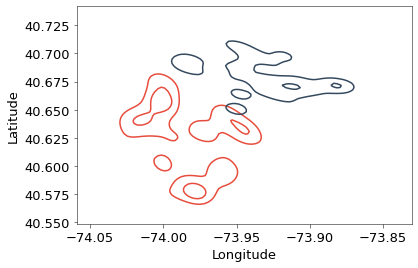

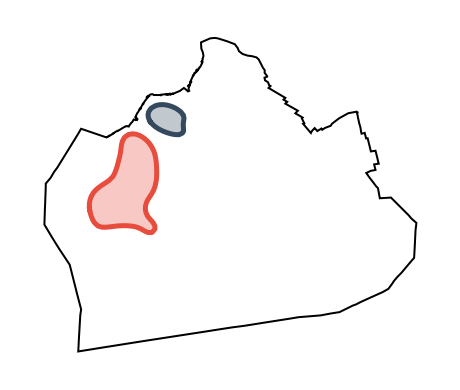

In [30]:
#View contours for Brooklyn pre covid
contours = get_view_contours_boro(boro_map, boro_pre, boro, n_levels, plot=True, save=False)

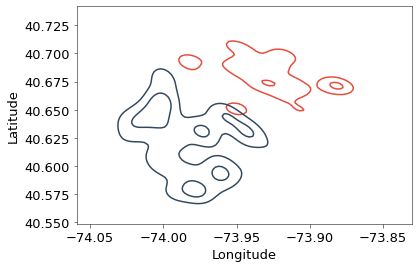

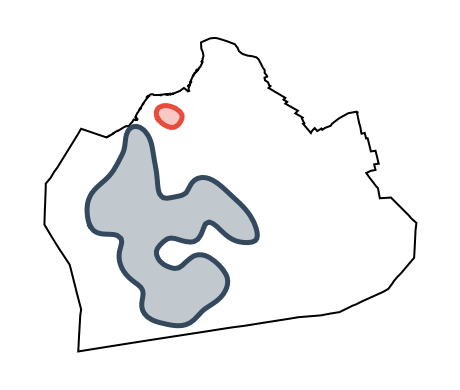

In [31]:
#View contours during Covid in Brooklyn
contours = get_view_contours_boro(boro_map, boro_cov, boro, n_levels, plot=True, save=False)

# Run algorithm prediction model

I will need more data pre covid and during covid.

Need 2 years of data for each.

First defining the training and testing periods. Then I will select the  precincts with the highest severe crimes.

After run a model and function that will predict the severe crimes in the test data.

You can then plot it to check accuracy. You can also calculate the global accuracy of the model!